# Spatialisation des naissances: analyse des données

## Introduction

Dans ce carnet nous expérimentons différentes méthodes de spatialisation de l'information:
* la projection de points avec diamètre de longueur proportionnelle à l'effectif des objets représentés
* la représentation de polygones correspondants aux États contemporains avec gradient de couleur en fonction de l'effectif des individus nés dans cette région: [cartes choroplèthes](https://fr.wikipedia.org/wiki/Carte_choropl%C3%A8the)
* un affichage dynamique de l'évolution dans le temps utilisant la librairie [Plotly Express](https://plotly.com/python/plotly-express/)


## Remarque importante

ATTENTION: ce carnet devient très lourd lorsque les cartes sont affichées. Il est __impératif de vider les résultats__ du carnet _entièrement_ avant d'effectuer un commit. Si le carnet (ou tout autre fichier dans le dépôt) dépasse les 200 MB, le _push_ vers Github sera impossible, et il sera compliqué de revenir en arrière.


NB En cas d'erreur si carnet trop de volume trop important on a l'[option décrite sur cette page](https://hkim-dev.github.io/programming/Managing-Large-Files-in-Git-Removing-Files-from-History/).

 
Le mieux, si on travaille seul, est de procéder ainsi:
* identifier le commit qui a créé le problème
* créer une copie locale dans un autre dossier des fichiers modifiés depuis, dans leur dernière version corrigée et allégée
* revenir au commit précédent: cf. [ces instructions](https://www.freecodecamp.org/news/git-reverting-to-previous-commit-how-to-revert-to-last-commit/)
* remettre les fichiers modifié dans le dossier tout en veillant à ce qu'il n'y ait aucun fichier de plus de 200 MB et pas de dépòt globalement de plus de 2 GB
* refaire un _commit_ et un _push_


## Les SIG


* L’[information géographique](https://fr.wikipedia.org/wiki/Information_g%C3%A9ographique) (attributs, relations spatiales, géométries)
* Les [systèmes d'information géographique](https://fr.wikipedia.org/wiki/Syst%C3%A8me_d%27information_g%C3%A9ographique) ou SIG : formes des géométries (du point à la 3D)
* Représentation de la réalité spatiale: géométries et données attributaires
   * Exemple: [Corine Land Cover](https://fr.wikipedia.org/wiki/Corine_Land_Cover), base de données européenne d'occupation du sol, financée par la communauté européenne


In [1]:
### Noter qu'il faudra avoir installé toutes les librairies nécessaires
# dans l'environnement conda utilisé pour exécuter ce carnet
import pandas as pd
import geopandas as gpd
#from shapely.geometry import LineString
from geopandas.tools import sjoin
from geodatasets import get_path
#import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px
from itables import init_notebook_mode, show
import numpy as np
#import seaborn as sns
import json
import IPython

In [2]:
### Librairies déjà installées avec Python
import pprint
import sqlite3 as sql
import sys
from importlib import reload


## Un premier affichage exploratoire

On utilise la librairie GeoPandas qui apporte de nombreuses fonctionnalités SIG


[Introduction à GeoPandas](https://geopandas.org/en/stable/getting_started/introduction.html)


Noter que les données de Wikidata sont stockées au format [WKT (Well Known Text)](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), par ex. POINT (37.61778 55.75583), et que la librairie GeoPanas va les transformer en géométries (type de valeur Python spécifique)

In [4]:
### Se connecter à la base de données
cn = sql.connect('../../data/conseil_national_import.db')
cn

In [65]:
### Préparer les données à afficher
# Il est plus simple d'effecture cette requête en SQL que dans Pandas
cur = cn.cursor()
l = cur.execute("""
SELECT ws.lieu_naissance_uri , ws.lieu_naissance, COUNT(*) eff, MAX(ws.lieu_coord) geo_coord, ws.code_lieu
FROM wdt_spatialisation ws 
-- il y a des erreurs dans Wikidata
WHERE ws.lieu_coord LIKE 'Point(%'
GROUP BY ws.lieu_naissance_uri, ws.lieu_naissance
-- exclut les valeurs vides
HAVING LENGTH(MAX(ws.lieu_coord)) > 7
ORDER BY eff DESC
""").fetchall()
print(len(l))
l[:2]

373


[('http://www.wikidata.org/entity/Q68347',
  'Disentis/Mustér',
  2,
  'Point(8.849722222 46.699722222)',
  'C'),
 ('http://www.wikidata.org/entity/Q69374',
  'Wallisellen',
  2,
  'Point(8.59672 47.41499)',
  'V')]

In [66]:
### Créer un dataframe contenant le résultat
df_l = pd.DataFrame(l, columns=['lieu_naissance_uri', 'lieu_naissance', 'effectif', 'geo_coord', 'code_lieu'])
df_l.head()

,lieu_naissance_uri,lieu_naissance,effectif,geo_coord,code_lieu
0,http://www.wikidata.org/entity/Q68347,Disentis/Mustér,2,Point(8.849722222 46.699722222),C
1,http://www.wikidata.org/entity/Q69374,Wallisellen,2,Point(8.59672 47.41499),V
2,http://www.wikidata.org/entity/Q69635,Wassen,2,Point(8.599166666 46.705555555),C
3,http://www.wikidata.org/entity/Q69639,Göschenen,2,Point(8.586388888 46.6675),C
4,http://www.wikidata.org/entity/Q10317,Fraubrunnen,1,Point(7.526944444 47.085),C


In [67]:
### Tester la fonction qui exécute la conversion en géométrie
# Cf. excursus concernant le nettoyage ci-dessous
s = gpd.GeoSeries.from_wkt(df_l.geo_coord[:5])
s

0    POINT (8.84972 46.69972)
1    POINT (8.59672 47.41499)
2    POINT (8.59917 46.70556)
3    POINT (8.58639 46.66750)
4    POINT (7.52694 47.08500)
dtype: geometry

In [98]:
### Créer un dataframe geopandas avec une colonne contenant une géométrie 
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
lieu_gdf = gpd.GeoDataFrame(
    df_l[['lieu_naissance_uri', 'lieu_naissance', 'effectif','code_lieu']],\
    geometry=gpd.GeoSeries.from_wkt(df_l.geo_coord.to_list()), crs="EPSG:4326"
)

# On dispose ainsi du DataFrame GeoPandas avec la colonne indispensable 'geometry'
lieu_gdf.head(3)

,lieu_naissance_uri,lieu_naissance,effectif,code_lieu,geometry
0,http://www.wikidata.org/entity/Q68347,Disentis/Mustér,2,C,POINT (8.84972 46.69972)
1,http://www.wikidata.org/entity/Q69374,Wallisellen,2,V,POINT (8.59672 47.41499)
2,http://www.wikidata.org/entity/Q69635,Wassen,2,C,POINT (8.59917 46.70556)


### Excursus concernant le nettoyage des données

Les fonctions de conversion entre Well Known Text (WKT) et géométries ne marchent que si les données sont propres et conformes.


Il y a donc tout un travail de nettoyage à effectuer sur les données de wikidata.
* Avec les stratégies qui suivent on a identifé les lignes erronées, puis on les a exclues en amont dans la requête SQL de départ.
* On aurait pu aussi passer un peu de temps pour nettoyer les données mais, vu l'approche heuristique, on a renoncé dans ce cas

In [99]:
### Avec cette stratégie, on peu inspecter les lignes qui posent problème
rl = []
i = 0
for e in df_l.geo_coord.to_list():
    try:
        a = gpd.GeoSeries.from_wkt([e])
    except Exception as e:
        print(i, e)
        print(df_l.iloc[i])
    rl.append(a)
    i += 1
#rl[:5]


In [100]:
### Avec stratégie on crée une fonction pour attribuer un code,
# ici le 999, aux lignes qui posent problème
def coord_split(c, i):
    try:
        a = round(float((c.split(' ')[i])), 4)
    except Exception as e:
        a = 999
    finally:
        pass
    #a = 999 
    return a       

In [101]:
### On applique ici la fonction

# ATTENTION : on illustre ici une stratégie dont
# on n'a pas besoin si les données sont propres en amont

df_l['longitudeBirth'] = df_l['geo_coord'].apply(lambda x: coord_split(x, 0))
df_l['latitudeBirth'] = df_l['geo_coord'].apply(lambda x : coord_split(x, 1))

## On cherche ensuite les lignes qui posent problème
df_l[df_l.longitudeBirth==999].sort_values(by='effectif', ascending=False)

,lieu_naissance_uri,lieu_naissance,effectif,geo_coord,code_lieu,longitudeBirth,latitudeBirth
0,http://www.wikidata.org/entity/Q68347,Disentis/Mustér,2,Point(8.849722222 46.699722222),C,999,999
2,http://www.wikidata.org/entity/Q69635,Wassen,2,Point(8.599166666 46.705555555),C,999,999
3,http://www.wikidata.org/entity/Q69639,Göschenen,2,Point(8.586388888 46.6675),C,999,999
1,http://www.wikidata.org/entity/Q69374,Wallisellen,2,Point(8.59672 47.41499),V,999,999
246,http://www.wikidata.org/entity/Q68230,Meyrin,1,Point(6.07911 46.23222),V,999,999
...,...,...,...,...,...,...,...
123,http://www.wikidata.org/entity/Q648,Lille,1,Point(3.0575 50.631944444),E,999,999
122,http://www.wikidata.org/entity/Q64755,Merenschwand,1,Point(8.3775 47.262222222),C,999,999
121,http://www.wikidata.org/entity/Q64752,Aristau,1,Point(8.36236 47.28563),C,999,999
120,http://www.wikidata.org/entity/Q64735,Bennwil,1,Point(7.77987 47.40317),C,999,999


## Réalisation de la première carte

In [102]:
### Inspection des données à afficher
lieu_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   lieu_naissance_uri  373 non-null    object  
 1   lieu_naissance      373 non-null    object  
 2   effectif            373 non-null    int64   
 3   code_lieu           373 non-null    object  
 4   geometry            373 non-null    geometry
dtypes: geometry(1), int64(1), object(3)
memory usage: 14.7+ KB


In [103]:
### Datasets Geopandas pour la couche de base
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

In [104]:
### Récupérer la carte de base, qui est aussi un DataFrame GeoPandas
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
world.head()

C:\Users\LZender\AppData\Local\Temp\ipykernel_23588\1957264229.py:2: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


### La question du géoréférencement des géométries

* Le [géoide](https://fr.wikipedia.org/wiki/G%C3%A9o%C3%AFde#%C3%80_quoi_sert_un_g%C3%A9o%C3%AFde_?)
* Le [système géodésique](https://fr.wikipedia.org/wiki/Syst%C3%A8me_g%C3%A9od%C3%A9sique)
* Le [système géodésique mondial WGS 84](https://fr.wikipedia.org/wiki/WGS_84)

In [105]:
### Types de géométries
pprint.pp(world.crs)
print('-------\n')
pprint.pp(lieu_gdf.crs)



<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

-------

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



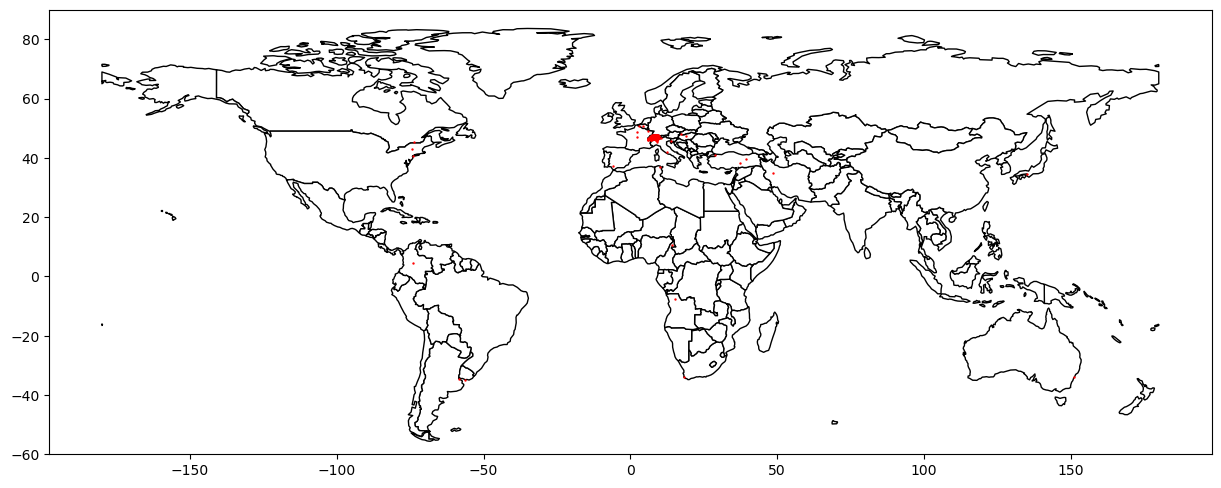

In [106]:
### Cartographier de toutes les naissances de personnes
# projection géographique

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

#ax.set_xlim([-0.1, 2])
ax.set_ylim([-60, 90])

# Noter que le diamètre du marqueur est fixe
lieu_gdf.plot(ax=ax, color="red", markersize=0.5)

plt.show()

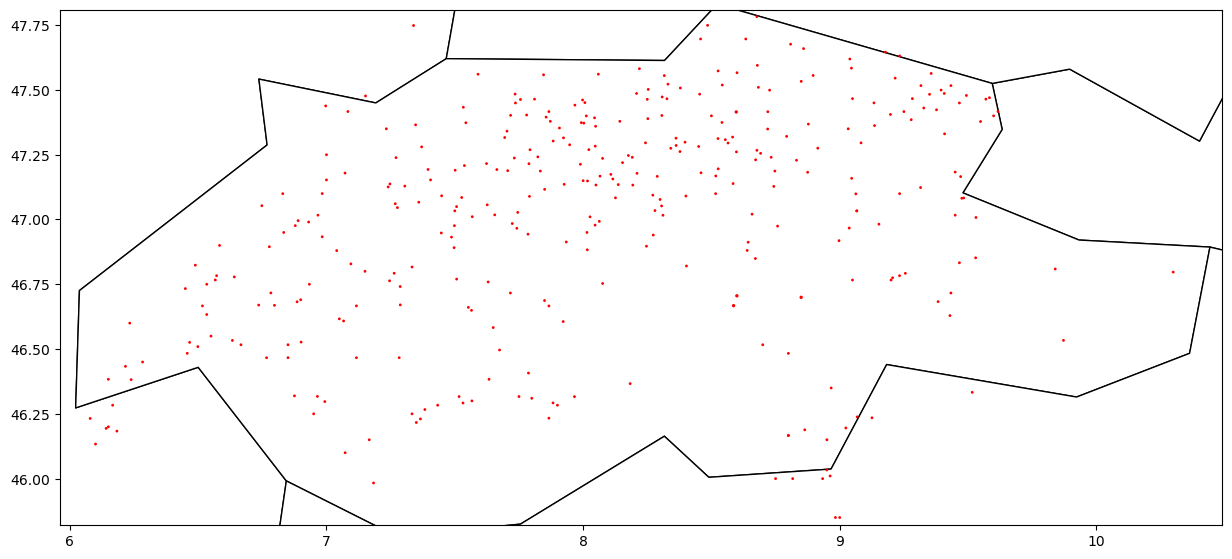

In [107]:
import matplotlib.pyplot as plt

ax = world.plot(color="white", edgecolor="black", figsize=(15,10))

# Définir les limites de longitude et de latitude pour la Suisse
ax.set_xlim([5.96, 10.49])
# lat
ax.set_ylim([45.82, 47.81])

# Noter que le diamètre du marqueur est proportionnel aux effectifs du lieu
lieu_gdf.plot(ax=ax, color="red", markersize=lieu_gdf.effectif)

plt.show()

In [108]:
### Transformation de la géographie
# vers une géométrie projetée: Web Mercator (EPSG 3857)
# Google Maps Global Mercator (EPGS 900913)

## Démarche effectuée à titre illustratif ici:
# indispensable si on utilise des données spatiales nationales 
# qui sont dans des coordonnées et projections spatiales propres 



### https://en.wikipedia.org/wiki/Web_Mercator_projection 

prj_world = world.copy(deep=True)
prj_world.geometry = prj_world.geometry.to_crs(900913)
pprint.pp(prj_world.crs)
print('------')
prj_lieu_gdf = lieu_gdf.copy(deep=True)
prj_lieu_gdf.geometry = prj_lieu_gdf.geometry.to_crs(900913)
pprint.pp(prj_lieu_gdf.crs)

<Derived Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

------
<Derived Projected CRS: EPSG:900913>
Name: Google Maps Global Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



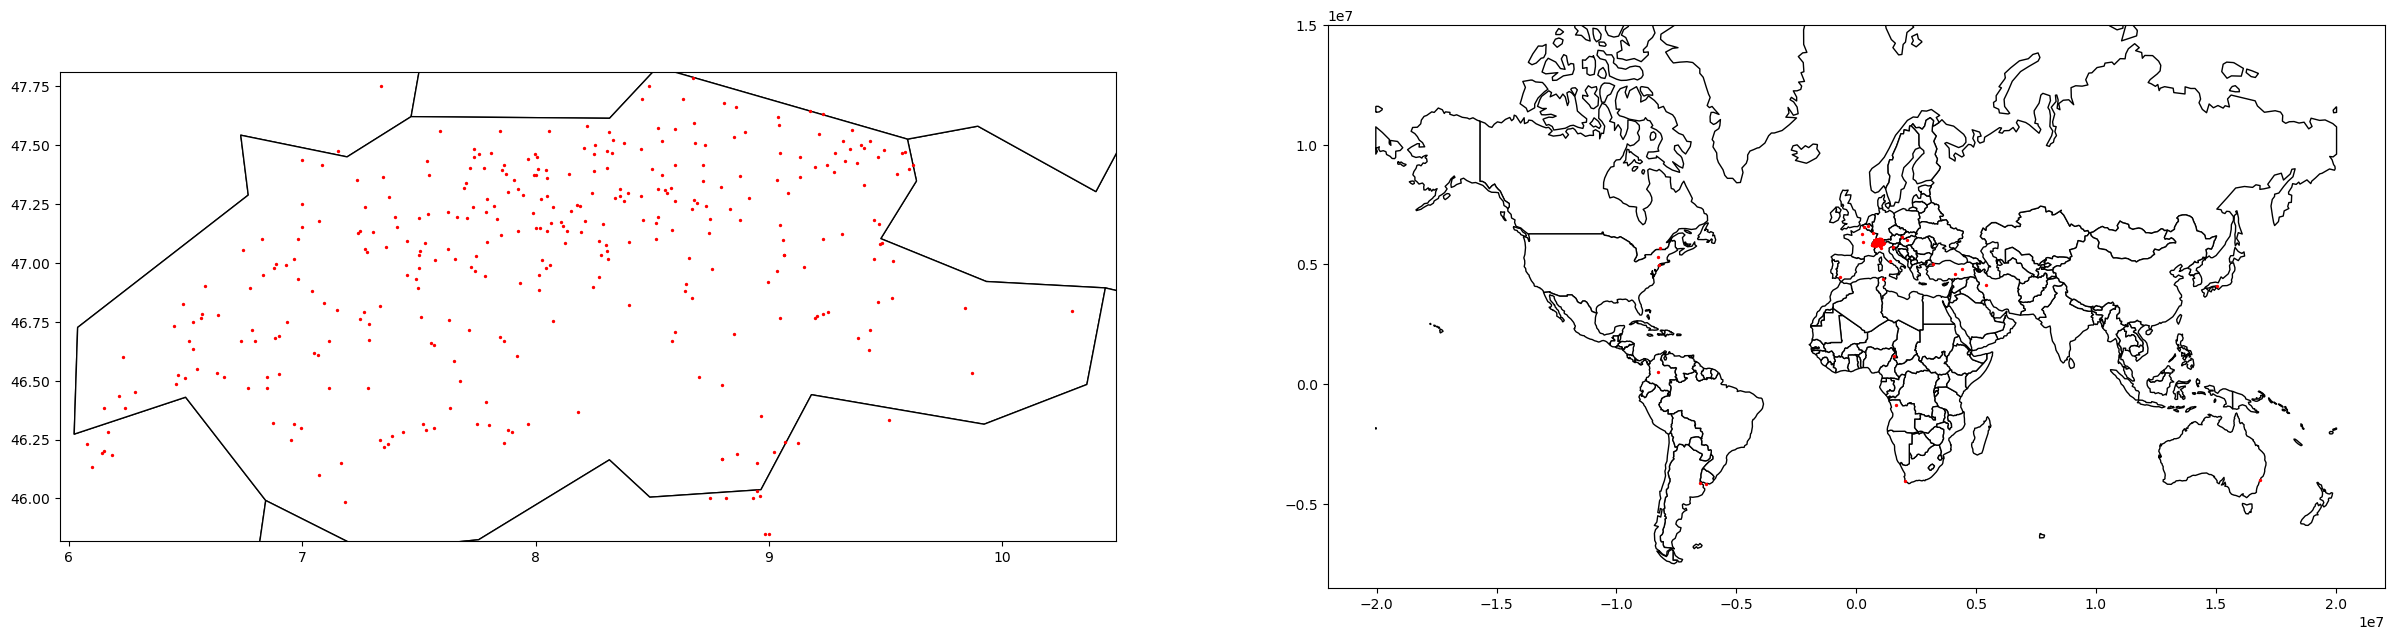

In [109]:
### Cartographier toutes les naissances de personnes
# avec deux systèmes de projection différents:
# géographique à gauche, Global Mercator à droite

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,20))

ax1 = world.plot(color="white", ax=axes[0], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax1.set_xlim([5.96, 10.49])
ax1.set_ylim([45.82, 47.81])

lieu_gdf.plot(ax=axes[0], color="red", markersize=2)

ax2 = prj_world.plot(color="white", ax=axes[1], edgecolor="black")
#ax.set_xlim([-0.1, 2])
ax2.set_ylim([-8.5*10e5, 1.5*10e6])

prj_lieu_gdf.plot(ax=axes[1], color="red", markersize=2)

plt.show()

## Affichage dynamique en relation avec les périodes


On teste ici un affichage dynamique avec la librairie Plotly express

In [148]:
### Préparer les données à afficher:
# on ne les regroupe pas encore afin de coder les périodes
cur = cn.cursor()
l = cur.execute("""
SELECT wp.annee_naissance ,ws.lieu_naissance_uri , ws.lieu_naissance , ws.lieu_coord  AS geo_coord, ws.code_lieu
FROM wdt_spatialisation ws 
join wdt_personnes wp on wp.fk_spatialisation_id = ws.id 
-- il y a des erreurs dans Wikidata
WHERE ws.lieu_coord LIKE 'Point(%'
""").fetchall()

df_all = pd.DataFrame(l, columns=['annee_naissance','lieu_naissance_uri', 'lieu_naissance', 'geo_coord', 'code_lieu'])
print(len(df_all))
df_all.head()


885


,annee_naissance,lieu_naissance_uri,lieu_naissance,geo_coord,code_lieu
0,1901,http://www.wikidata.org/entity/Q72,Zürich,Point(8.541111111 47.374444444),V
1,1901,http://www.wikidata.org/entity/Q69126,Möhlin,Point(7.845833333 47.558333333),C
2,1901,http://www.wikidata.org/entity/Q7133,Grosswangen,Point(8.05 47.133055555),C
3,1901,http://www.wikidata.org/entity/Q70586,Lussery-Villars,Point(6.533333333 46.633333333),C
4,1901,http://www.wikidata.org/entity/Q10317,Fraubrunnen,Point(7.526944444 47.085),C


### Coder les données avec les périodes

In [127]:
### Préparer la liste des périodes
l_p = [1901, 1915, 1930, 1946, 1976, 1997]
##l2 = list(range(1901, 2002, 25))
## l_p = l1 + l2
print(l_p)

[1901, 1915, 1930, 1946, 1976, 1997]


In [128]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_all['annee_naissance'] = df_all['annee_naissance'].astype(int)
df_spat['generations'] = pd.cut(df_spat['annee_naissance'], l_p, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_spat['generations'] = df_spat['generations'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_spat.head(3)

,annee_naissance,lieu_naissance_uri,lieu_naissance,geo_coord,code_lieu,generations
0,1901,http://www.wikidata.org/entity/Q72,Zürich,Point(8.541111111 47.374444444),V,1901-1914
1,1901,http://www.wikidata.org/entity/Q69126,Möhlin,Point(7.845833333 47.558333333),C,1901-1914
2,1901,http://www.wikidata.org/entity/Q7133,Grosswangen,Point(8.05 47.133055555),C,1901-1914


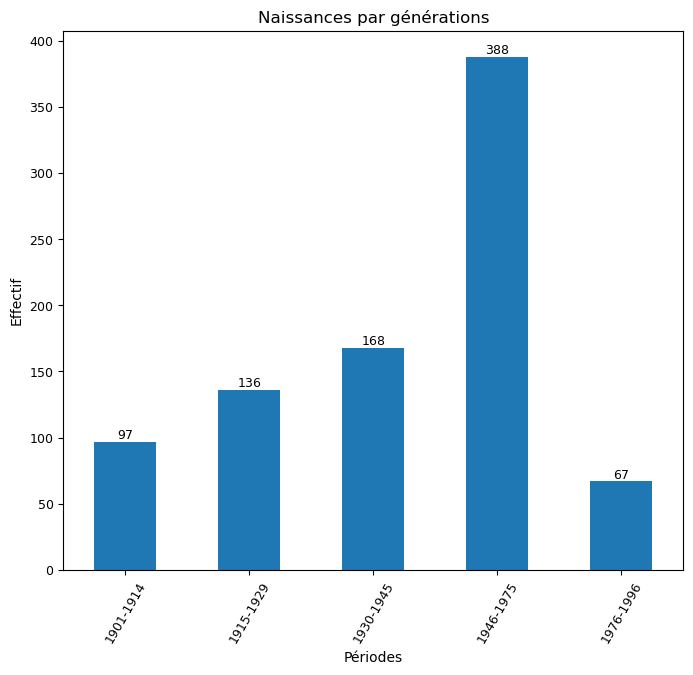

In [129]:
ax = df_spat.groupby(by='generations', observed=True).size().plot(kind='bar',
                                            rot=60, fontsize=9, figsize=(8,7))
ax.bar_label(ax.containers[0], fontsize=9)
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par générations')
plt.show()

In [135]:
### Créer une nouvelle table contenant le DataFrame
# Si on tente de la recréer, alor qu'elle existe déjà,
# un message d'erreur est renvoyé
try:
    l = df_spat[['generations', 'lieu_naissance_uri', 'lieu_naissance', 'geo_coord', 'code_lieu']]\
             .to_sql(name='wdt_generations_lieu_naissance', con=cn, if_exists='replace')
except Exception as e:
    print('Erreur: ',  e)

### Grouper et compter

On passe par la base de données parce que c'est plus simple qu'utiliser directement Pandas.


Noter que désormais ce sont les naissances (regroupées en périodes), et leur effectif, qui sont la variable étudiée 


In [136]:
q1 = """
SELECT generations, lieu_naissance, geo_coord, COUNT(*) as effectif
FROM wdt_generations_lieu_naissance wgln
GROUP BY generations, lieu_naissance_uri, lieu_naissance, geo_coord
"""
### Préparer les données à afficher
cur = cn.cursor()
l = cur.execute(q1).fetchall()
print(len(l))
l[:2]

482


[('1901-1914', 'Fraubrunnen', 'Point(7.526944444 47.085)', 1),
 ('1901-1914', 'Biel/Bienne', 'Point(7.247222222 47.137222222)', 2)]

In [137]:
### Préparation des données à afficher dans Plotly Express
# ici on utilisé les coordonnées géographiques
df_gen_gr = pd.DataFrame(l, columns=['periode', 'lieu', 'geo_coord', 'eff'])
df_gen_gr.geo_coord = df_gen_gr.geo_coord.apply(lambda x: x.replace('Point(', '')\
                                .replace(')',''))
df_gen_gr['long'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[0])), 4))
df_gen_gr['lat'] = df_gen_gr.geo_coord\
    .apply(lambda x: round(float((x.split(' ')[1])), 4))

df_gen_gr.head()

,periode,lieu,geo_coord,eff,long,lat
0,1901-1914,Fraubrunnen,7.526944444 47.085,1,7.5269,47.0850
1,1901-1914,Biel/Bienne,7.247222222 47.137222222,2,7.2472,47.1372
2,1901-1914,Nidau,7.240277777 47.125555555,2,7.2403,47.1256
3,1901-1914,Entlebuch,8.063055555 46.992777777,1,8.0631,46.9928
4,1901-1914,Näfels,9.062777777 47.098888888,2,9.0628,47.0989


In [138]:
import plotly.express as px
import plotly.graph_objects as go
import json
import requests

# Assurez-vous que 'df_gen_gr' contient des données valides pour la Suisse

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_gen_gr.eff]

# Téléchargez le GeoJSON des frontières de la Suisse (ou utilisez un fichier local)
url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/switzerland.geojson'
response = requests.get(url)
switzerland_geojson = response.json()

fig = px.scatter_geo(
    df_gen_gr,
    lat="lat",
    lon="long",
    size=size,
    hover_name="lieu",
    animation_frame="periode",
    width=1400, height=600,
    color_discrete_sequence=['red'],
    title="Evolution des lieux de naissance"
).update_layout(
        margin={"l": 0, "r": 20, "t": 30, "b": 0},
        geo=dict(
            center=dict(lat=46.8182, lon=8.2275),  # Centre approximatif de la Suisse
            projection_scale=30,  # Ajustez cette valeur pour zoomer (plus grand -> plus de zoom)
        )
)

# Ajoutez les frontières de la Suisse
fig.add_trace(
    go.Choropleth(
        geojson=switzerland_geojson,
        locations=["CHE"],  # Code pays ISO pour la Suisse
        z=[0],  # Une valeur factice
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Transparence
        showscale=False,
        geo='geo'
    )
)

# Ajoutez une couche pour dessiner les contours des frontières
fig.update_geos(
    showcountries=True, countrycolor="Black",
    showcoastlines=True, coastlinecolor="Black",
    showland=True, landcolor="white",
    fitbounds="locations"
)

# On peut ici augmenter la durée des étapes
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1500


### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet
f_address = "images/lieu_naissance_points.html"
fig.write_html(f_address)
fig.show()


UnicodeEncodeError: 'charmap' codec can't encode character '\u25c4' in position 293642: character maps to <undefined>

## Grouper et compter les naissances par État contemporain

In [139]:
### Polygones des États contemporains
print(len(world))
world.head()

177


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [140]:
world_s = world[['name','geometry']].copy(deep=True)
world_s

,name,geometry
0,Fiji,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Tanzania,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,W. Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...
172,Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [141]:
### Transformer les coordonnées géogr. en points
df_gen_gr_gdf = gpd.GeoDataFrame(
    df_gen_gr[['periode', 'lieu', 'eff']],\
    geometry=gpd.points_from_xy(df_gen_gr.long, df_gen_gr.lat), crs="EPSG:4326"
)

df_gen_gr_gdf.head(3)


,periode,lieu,eff,geometry
0,1901-1914,Fraubrunnen,1,POINT (7.52690 47.08500)
1,1901-1914,Biel/Bienne,2,POINT (7.24720 47.13720)
2,1901-1914,Nidau,2,POINT (7.24030 47.12560)


In [146]:
### Vérification
df_gen_gr_gdf.loc[df_gen_gr_gdf['lieu']=='Neuchâtel']

,periode,lieu,eff,geometry
56,1901-1914,Neuchâtel,1,POINT (6.93060 46.99030)
141,1915-1929,Neuchâtel,1,POINT (6.93060 46.99030)
237,1930-1945,Neuchâtel,4,POINT (6.93060 46.99030)
398,1946-1975,Neuchâtel,8,POINT (6.93060 46.99030)
469,1976-1996,Neuchâtel,1,POINT (6.93060 46.99030)


### Préparation de la fonction qui va créer les données à afficher

In [147]:

# https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html
# https://stackoverflow.com/questions/69644523/count-points-in-polygon-and-write-result-to-geodataframe


dfa = world_s.copy(deep=True)
dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == '1901-1914']

### jointure spatiale
dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
dfa = dfa.join(dfc, on='name', how="left")
dfa.eff.fillna(value=0, inplace=True)
dfa['eff'] = dfa['eff'].astype(int)

dfa = dfa.assign(periode = '1901-1914')

dfa[dfa.eff > 0].sort_values(by='eff', ascending=False).head()



,name,geometry,eff,index_right,periode
127,Switzerland,"POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...",91,8636.0,1901-1914
43,France,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",5,129.0,1901-1914
141,Italy,"MULTIPOLYGON (((10.44270 46.89355, 11.04856 46...",1,141.0,1901-1914


In [122]:
### Transformer en json pour afficher dans Plotly Express
countries_polygons = dfa[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

In [123]:
### Représenter la densité de naissances de mathématiciens par pays
# uniteuemnt pour une période données
# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in dfa.eff]

fig = px.choropleth_mapbox(
    dfa,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur 20 définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 20),
    width=1000, height=600,
    title="Evolution des lieux de naissance"
)

fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
### Créer la liste des périodes
lp = df_gen_gr.groupby(by='periode').size().index.to_list()
lp

In [ ]:
### Préparer les données, un DataFrame avec jointure spatiale
# par période 
frames=[]
for e in lp:
    
    dfa = world_s.copy(deep=True)
    dfb = df_gen_gr_gdf[df_gen_gr_gdf.periode == e]
    
    ### jointure spatiale
    dfc =  gpd.sjoin(dfb, dfa).groupby("name").sum(numeric_only=True)
    dfa = dfa.join(dfc, on='name', how="left")
    dfa.eff.fillna(value=0, inplace=True)
    dfa['eff'] = dfa['eff'].astype(int)

    dfa = dfa.assign(periode = e)

    frames.append(dfa)


### Concaténation des DataFrames
df_result = pd.concat(frames)
df_result=df_result.reset_index()
df_result.tail()


In [ ]:
### inspection des données pour un pays
df_result[df_result.name=='France']

In [ ]:
### Transformer en json pour affichage dans Plotly
countries_polygons = df_result[['name', 'geometry']]
countries_polygons.index = countries_polygons['name']
countries_polygons = countries_polygons.drop(['name'], axis=1)
countries_polygons_json = json.loads(countries_polygons.to_json())

In [ ]:
### Représenter la densité de naissances de mathématiciens par pays
# carte interactive.
# Noter que l'exécution peutprendre quelques minutes

# https://plotly.com/python/animations/
# https://plotly.com/python-api-reference/generated/plotly.express.choropleth_mapbox.html
# https://medium.com/@lucas_bromerchenkel/choropleth-maps-with-time-sliders-using-plotly-df6e19e5f90c

# np.log(s) * 1000
size = [s if s != 0 else 0 for s in df_result.eff]

fig = px.choropleth_mapbox(
    df_result,
    geojson=countries_polygons_json,
    locations="name",
    color="eff",
    mapbox_style='white-bg',
    zoom=1,
    color_continuous_scale='blues',
    ### valeur 20 définie en fonction de la distribution par pays
    # expérimenter en changeant la valeur
    range_color=(1, 200),
    animation_frame="periode",
    width=1000, height=600,
    title="Evolution des lieux de naissance"
).update_layout(
    #mapbox={"style": "carto-positron", "zoom":10},
    margin={"l": 0, "r": 0, "t": 30, "b": 0}
)

fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1000

### Noter qu'on enregistre l'image afin de pouvoir l'ouvrir dans un navigateur
# et l'inspecter sans exécuter le code Python du carnet
f_address = "images/birth_places_choropleth.html"
fig.write_html(f_address)

fig.show()